# Logistic regression, posterior predictive distribution $p(x_n | x_{n-1}, D)$ 

Source code for the learning (only forward) is [on Github](https://github.com/mathymess/reversibility-of-processes/blob/95319d3d169af99f627973d618b698b8ad5ec5b4/bayesian.py).

I set up a BNN and draw 100 samples from $p(x_n | x_{n-1}, D)$ (forward) and from $p(x_{n-1} | x_{n}, D)$ (backward) using MCMC (Markov Chain Monte Carlo).
Window_len=1.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [8]:
x_test = torch.linspace(0.001, 0.999, 1000)
y_test = (4.0 * x_test * (1 - x_test))
print(x_test.shape, y_test.shape)

torch.Size([1000]) torch.Size([1000])


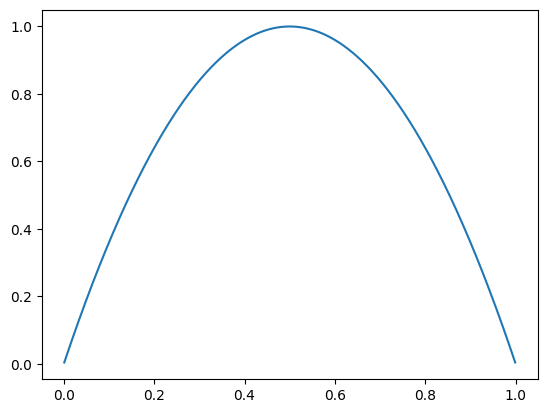

In [9]:
plt.plot(x_test, y_test)
plt.show()

In [3]:
preds_f = torch.load("20230723_preds.torch")
preds_b = torch.load("20230723_preds.backward.torch")
print(preds_b.shape, preds_f.shape)

torch.Size([100, 1000]) torch.Size([100, 1000])


In [ ]:
plt.plot(x_test, y_test)
plt.plot(x_test, preds_f.)
plt.show()

In [3]:
def plot_predictions(preds):
    y_pred = preds.mean(axis=0)
    y_std = preds.std(axis=0)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X")
    plt.ylabel("Y")

    ax.plot(x_test, y_test, 'b-', linewidth=3, label="true function")
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend()

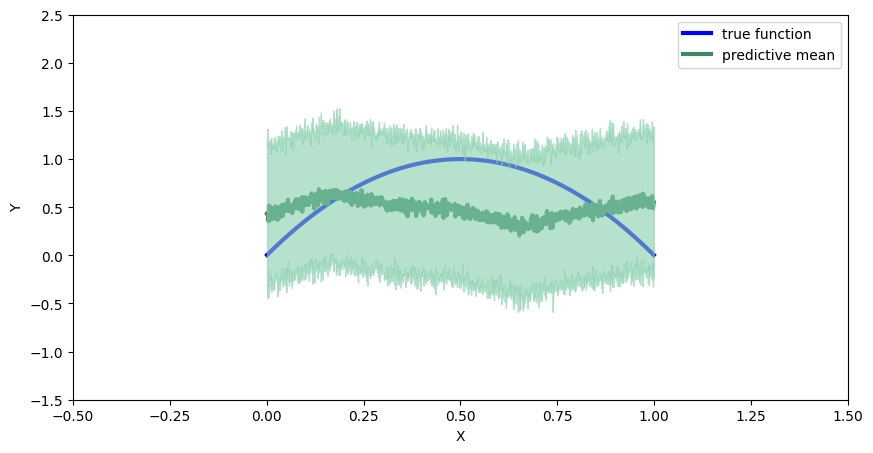

In [18]:
plot_predictions(preds_b)

In [8]:
preds_f = torch.load("20230724_preds/garch02/samples.forward.torch")["obs"]
preds_b = torch.load("20230724_preds/garch02/samples.backward.torch")["obs"]
targets = torch.load("20230724_preds/garch02/targets_test.torch")
print(preds_b.shape, preds_f.shape)

torch.Size([20, 997]) torch.Size([20, 997])


In [12]:
((targets - preds_f.mean(axis=0)) ** 2).mean()

tensor(1.3318)